### Model predykcyjny cen usług taxi w Nowym Jorku z algorytmu XGBoost

#### Słowem wstepu

Nazwa XGBoost to akronim od angielskiego “Extreme Gradient Boosting”. O ile w rodzimym języku nazwa ta brzmi chwytliwie, o tyle po polsku wyraża ją najlepiej w wątliwym stopniu chwytliwa fraza "ekstremalne gradientowe wzmacnianinie". Rozwiązania z dziedziny "boosting" łączą wiele "słabych", prostych rozwiązań w jedno większe oraz uwzględniają błąd już wygenerowanych elementów przy tworzeniu kolejnych. W przypadku tego algorytmu, mnogość "słabych rozwiązań" ma odzwierciedlenie w mnogości drzew decyzyjnych. Algorytm XGBoost w najlepszym stopniu przedstawia poniższa klasyfikacja:

1) algorytm klasyfikacyjno-regresyjny:

- przeznaczony głównie do klasyfikacji i regresji,
- optymalizuje wiele różnych funkcji scoringowych i błędu,
- obsługuje funkcje docelowe: softmax, logit, liniowa, poissona, gamma, 

2) oparty na drzewach:

- bazowym estymatorem są drzewa decyzyjne,
- algorytm złożony - ensemble,
- algorytm typu boosting – zwiększenie wagi błędnych przykładów,
- każde kolejne drzewo uczy się na błędach poprzedniego,
    
3) dobrze zrównoleglony: 
    
- drzewa są zależne od siebie,
- zrównoleglenie następuje na poziomie pojedynczego drzewa – przy     budowaniu kolejnych węzłów,

i, co bardzo ważne... 

- ##### XGBoost używa skompresowanego formatu danych, dzięki czemu oszczędzana jest pamięć.

W pierwszej kolejności zaimportujmy niezbędne pakiety.

In [1]:
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import xgboost as xgb
import os
import dask.dataframe as dd

Wczytajmy dane. Link do danych i opisu problematyki predykcyjnej: 
[LINK](https://www.kaggle.com/c/new-york-city-taxi-fare-prediction)

#dask
traintypes = {'fare_amount': 'float32',
              'pickup_datetime': 'str',
              'pickup_longitude': 'float32',
              'pickup_latitude': 'float32',
              'dropoff_longitude': 'float32',
              'dropoff_latitude': 'float32',
              'passenger_count': 'uint8'}

cols = list(traintypes.keys())
ddf = dd.read_csv('train.csv', usecols=cols, dtype=traintypes)
dfTrening = ddf.sample(frac=0.04)
dfTrening = dfTrening.compute()
dfTrening.dtypes

len(dfTrening)

dfTrening.to_csv("C:/Users/akomo/Desktop/WAD_projekty/predykcja/Wylosowane.csv",sep=',')

In [2]:
dfTrening =  pd.read_csv('train.csv', nrows = 2200000) #lub 6000000
dfTrening.dtypes

key                   object
fare_amount          float64
pickup_datetime       object
pickup_longitude     float64
pickup_latitude      float64
dropoff_longitude    float64
dropoff_latitude     float64
passenger_count        int64
dtype: object

### Preprocessing

Pierwszym etapem jest usunięcie ze zbioru wartości null

In [3]:
print(dfTrening.isnull().sum())

key                   0
fare_amount           0
pickup_datetime       0
pickup_longitude      0
pickup_latitude       0
dropoff_longitude    15
dropoff_latitude     15
passenger_count       0
dtype: int64


In [4]:
dfTrening = dfTrening.dropna(how = 'any', axis = 'rows')

Szybkie spojrzenie na strukturę danych:

In [5]:
dfTrening.head()

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21 UTC,-73.844311,40.721319,-73.841610,40.712278,1
1,2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:16 UTC,-74.016048,40.711303,-73.979268,40.782004,1
2,2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00 UTC,-73.982738,40.761270,-73.991242,40.750562,2
3,2012-04-21 04:30:42.0000001,7.7,2012-04-21 04:30:42 UTC,-73.987130,40.733143,-73.991567,40.758092,1
4,2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00 UTC,-73.968095,40.768008,-73.956655,40.783762,1


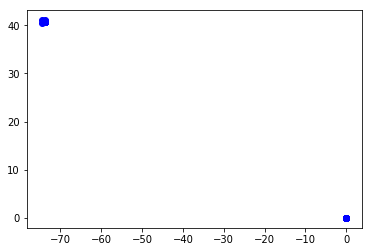

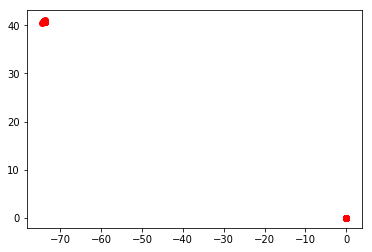

In [6]:
plt.scatter(dfTrening.iloc[:1500]['pickup_longitude'],dfTrening.iloc[:1500]['pickup_latitude'],color='b')
plt.show()
plt.scatter(dfTrening.iloc[:1500]['dropoff_longitude'],dfTrening.iloc[:1500]['dropoff_latitude'],color = 'r')
plt.show()

Oraz na rozkład samych wartości:

In [7]:
dfTrening.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,2.199985e+06,2.199985e+06,2.199985e+06,2.199985e+06,2.199985e+06,2.199985e+06
mean,1.134555e+01,-7.252072e+01,3.992612e+01,-7.252076e+01,3.992526e+01,1.684385e+00
std,9.843951e+00,1.301416e+01,8.203660e+00,1.265272e+01,1.025209e+01,1.329046e+00
min,-6.200000e+01,-3.377681e+03,-3.458665e+03,-3.383297e+03,-3.461541e+03,0.000000e+00
25%,6.000000e+00,-7.399208e+01,4.073492e+01,-7.399140e+01,4.073400e+01,1.000000e+00
50%,8.500000e+00,-7.398181e+01,4.075263e+01,-7.398016e+01,4.075312e+01,1.000000e+00
75%,1.250000e+01,-7.396713e+01,4.076710e+01,-7.396368e+01,4.076809e+01,2.000000e+00
max,1.273310e+03,2.856442e+03,2.621628e+03,3.414307e+03,3.345917e+03,2.080000e+02


Kolejnym etapem preprocessingu wczytanych danych jest wykonanie następujących operacji:

* usunięcie rekordów z ujemnym taxi-fare
* usunięcie rekordów ze współrzędnymi bliskimi (0,0), ponieważ Nowy Jork ma współrzędne ok. (40,-74)
* usunięcie rekordów z przesadną (bardzo dużą) liczbą parametrów

In [8]:
dfTrening = dfTrening[(dfTrening.fare_amount > 0) & 
            (dfTrening.pickup_longitude > -80) & (dfTrening.pickup_longitude < -70) &
            (dfTrening.pickup_latitude > 35) & (dfTrening.pickup_latitude < 45) &
            (dfTrening.dropoff_longitude > -80) & (dfTrening.dropoff_longitude < -70) &
            (dfTrening.dropoff_latitude > 35) & (dfTrening.dropoff_latitude < 45) &
            (dfTrening.passenger_count > 0) & (dfTrening.passenger_count < 10)]

print(len(dfTrening))

2146912


### Dodanie dla danych nowych atrybutów 

Dodanie dla rekordów z tabeli danych poniższych atrybutów znacząco poprawiło skuteczność modelu predykcyjnego: 
* total_distance - odległość końca podróży od jej początku  
* dzien tygodnia / miesiac / dzien / godzina z daty  
* odległość od najbliższego lotniska/lotnisk - zazwyczaj droższe przejazdy

W tej części zdefiniujemy funkcję, która liczy odległość pomiędzy począkiem, a końcem trasy stosując metodę odległości na
sferze. Odległość na sferze, którą jest Ziemia, z niewielkim błędem wyliczamy ze wzoru:
$$d = R*df$$,
gdzie R - promień Ziemi równy 6370km, df - df - kąt mierzony pomiędzy dwoma punktami na sferze, ale mierzony w 
radianach.
Ponieważ nasze dystane są stosunkowo niewielkie, dlatego korzystamy tu z "ulepszenia" powyższych wyliczeń, czyli z tzw.
dystansu haversine wyliczanego ze wzoru:
$$d = 2*R*\sqrt{(sin^2(\frac{\Delta\phi}{2})+cos\phi_1*cos\phi_2*sin^2(\frac{\Delta\lambda}{2}))},$$
gdzie $$\phi_1,\phi_2$$ są szerokościami geograficznymi punktów,
$$\lambda_1,\lambda_2$$ są długościami geograficznymi punktów,
$$\Delta\phi=\phi_2-\phi_1$$ jest to różnica szerokości geograficznych punktu startowego i końcowego trasy,
$$\Delta\lambda=\lambda_2-\lambda_1$$ jest to jest to różnica długości geograficznych punktu startowego i końcowego trasy.

Kolejna funkcja jaką definiujemy będzie liczyła początkowy namiar (ang. bearing). Przez namiar określamy kierunek od obserwatora do namierzanego obiektu wyrażony w miarze kątowej. W naszym przypadku namiar liczyć będziemy między punktem początkowym a końcowym. W celu obliczenia namiaru korzystamy z następującego wzoru:
$$\Theta=atan2(sin(\Delta\lambda)*cos(\phi_2), cos(\phi_1)*sin(\phi_2)−sin(\phi_1)*cos(\phi_2)*cos(\Delta\lambda)),$$
gdzie $$\phi_1,\phi_2$$ są szerokościami geograficznymi punktów,
$$\lambda_1,\lambda_2$$ są długościami geograficznymi punktów,
$$\Delta\lambda=\lambda_2-\lambda_1$$ jest to jest to różnica długości geograficznych punktu startowego i końcowego trasy.

Następnie definiujemy funkcję, która wyznacza odległość naszych punktów od wybranych przez nas miejsc charakterystycznych tj.
lotnisko John F. Kennedy, Newark Liberty, LaGuardia, Statua Wolności oraz New york Central. Do każdej trasy wyznaczamy dwie
odległości za pomocą wyżej przedstawionego wzoru. Jedna to odległość punktu początkowego od punktu charakterystycznego, a druga to odległość punktu charakterystycznego od punktu końcowego. Ponieważ odległości punktów początkowych od punktów charakterystycznych jest zazwyczaj duża, dlatego do odległości od punktu początkowego do punktu charakterystycznego dodajemy odległość powrotną, co zwiększa cenę za przejazd.

Kolejnym krokiem jest podział daty i godziny na składowe: godzina, dzień, miesiąc,dzień tygodnia i rok

Ostatecznie do naszej tabeli dodajemy podział daty, odległość naszego punktu od punktów charakterystycznych(ponieważ jazda
w te miejsca jest droższa, więc cena za przejazd będzie liczona inaczej) oraz normalną odległość punktu początkowego od punktu
końcowego

In [9]:
def sphere_dist(pickup_lat, pickup_lon, dropoff_lat, dropoff_lon):
    
    """
    Funkcja zwraca "wielki promień" pomiędzy początkiem i końcem.
    """
    #zdefiniujmy promień Ziemi (km)
    R_earth = 6371
    #Zamieniamy stopnie na radiany
    
    pickup_lat, pickup_lon, dropoff_lat, dropoff_lon = map(np.radians,
                                                             [pickup_lat, pickup_lon,
                                                              dropoff_lat, dropoff_lon])
    #Obliczamy różnicę współrzędnych
    dlat = dropoff_lat - pickup_lat
    dlon = dropoff_lon - pickup_lon
    
    #Obliczamy dystans "haversine"
    a = np.sin(dlat/2.0)**2 + np.cos(pickup_lat) * np.cos(dropoff_lat) * np.sin(dlon/2.0)**2
    
    return 2 * R_earth * np.arcsin(np.sqrt(a))

def sphere_dist_bear(pickup_lat, pickup_lon, dropoff_lat, dropoff_lon):
    """
    Funkcja zwraca "wielki promień" pomiędzy początkiem i końcem.
    """
    #zdefiniujmy promień Ziemi (km)
    R_earth = 6371
    #Zamieniamy stopnie na radiany
    pickup_lat, pickup_lon, dropoff_lat, dropoff_lon = map(np.radians,
                                                             [pickup_lat, pickup_lon, 
                                                              dropoff_lat, dropoff_lon])
    ##Obliczamy różnicę współrzędnych
    dlat = dropoff_lat - pickup_lat
    dlon = pickup_lon - dropoff_lon
    
    #Obliczamy początkowy namiar
    a = np.arctan2(np.sin(dlon * np.cos(dropoff_lat)),np.cos(pickup_lat) * np.sin(dropoff_lat) - np.sin(pickup_lat) * np.cos(dropoff_lat) * np.cos(dlon))
    return a

def add_airport_dist(dataset):
    """
    Odległości od znanych lotnisk/Statuy
    JFK: John F. Kennedy International Airport
    EWR: Newark Liberty International Airport
    LGA: LaGuardia Airport
    SOL: Statue of Liberty 
    NYC: Newyork Central
    """
    jfk_coord = (40.639722, -73.778889)
    ewr_coord = (40.6925, -74.168611)
    lga_coord = (40.77725, -73.872611)
    sol_coord = (40.6892,-74.0445) # Statua Wolności - może odrzucić?
    nyc_coord = (40.7141667,-74.0063889) 
    
    pickup_lat = dataset['pickup_latitude']
    dropoff_lat = dataset['dropoff_latitude']
    pickup_lon = dataset['pickup_longitude']
    dropoff_lon = dataset['dropoff_longitude']
    
    pickup_jfk = sphere_dist(pickup_lat, pickup_lon, jfk_coord[0], jfk_coord[1]) 
    dropoff_jfk = sphere_dist(jfk_coord[0], jfk_coord[1], dropoff_lat, dropoff_lon) 
    pickup_ewr = sphere_dist(pickup_lat, pickup_lon, ewr_coord[0], ewr_coord[1])
    dropoff_ewr = sphere_dist(ewr_coord[0], ewr_coord[1], dropoff_lat, dropoff_lon) 
    pickup_lga = sphere_dist(pickup_lat, pickup_lon, lga_coord[0], lga_coord[1]) 
    dropoff_lga = sphere_dist(lga_coord[0], lga_coord[1], dropoff_lat, dropoff_lon)
    pickup_sol = sphere_dist(pickup_lat, pickup_lon, sol_coord[0], sol_coord[1]) 
    dropoff_sol = sphere_dist(sol_coord[0], sol_coord[1], dropoff_lat, dropoff_lon)
    pickup_nyc = sphere_dist(pickup_lat, pickup_lon, nyc_coord[0], nyc_coord[1]) 
    dropoff_nyc = sphere_dist(nyc_coord[0], nyc_coord[1], dropoff_lat, dropoff_lon)
    
    
    
    dataset['jfk_dist'] = pickup_jfk + dropoff_jfk
    dataset['ewr_dist'] = pickup_ewr + dropoff_ewr
    dataset['lga_dist'] = pickup_lga + dropoff_lga
    dataset['sol_dist'] = pickup_sol + dropoff_sol
    dataset['nyc_dist'] = pickup_nyc + dropoff_nyc
    
    return dataset

    
def add_datetime_info(dataset):
    #Convert to datetime format
    dataset['pickup_datetime'] = pd.to_datetime(dataset['pickup_datetime'],format="%Y-%m-%d %H:%M:%S UTC")
    
    dataset['hour'] = dataset.pickup_datetime.dt.hour
    dataset['day'] = dataset.pickup_datetime.dt.day
    dataset['month'] = dataset.pickup_datetime.dt.month
    dataset['weekday'] = dataset.pickup_datetime.dt.weekday
    dataset['year'] = dataset.pickup_datetime.dt.year
    
    return dataset

dfTrening = add_datetime_info(dfTrening)
dfTrening = add_airport_dist(dfTrening)
dfTrening['distance'] = sphere_dist(dfTrening['pickup_latitude'], dfTrening['pickup_longitude'], 
                                   dfTrening['dropoff_latitude'] , dfTrening['dropoff_longitude'])
dfTrening['bearing'] = sphere_dist_bear(dfTrening['pickup_latitude'], dfTrening['pickup_longitude'], 
                                   dfTrening['dropoff_latitude'] , dfTrening['dropoff_longitude'])  

dfTrening.head()

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,hour,day,month,weekday,year,jfk_dist,ewr_dist,lga_dist,sol_dist,nyc_dist,distance,bearing
0,2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21,-73.844311,40.721319,-73.841610,40.712278,1,17,15,6,0,2009,20.265840,55.176046,14.342611,34.543548,27.572573,1.030764,-2.918897
1,2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:16,-74.016048,40.711303,-73.979268,40.782004,1,16,5,1,1,2010,44.667679,31.832358,23.130775,15.125872,8.755732,8.450134,-0.375217
2,2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00,-73.982738,40.761270,-73.991242,40.750562,2,0,18,8,3,2011,43.597686,33.712082,19.865289,17.722624,9.847344,1.389525,2.599961
3,2012-04-21 04:30:42.0000001,7.7,2012-04-21 04:30:42,-73.987130,40.733143,-73.991567,40.758092,1,4,21,4,5,2012,42.642965,32.556289,21.063132,15.738963,7.703421,2.799270,0.133905
4,2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00,-73.968095,40.768008,-73.956655,40.783762,1,7,9,3,1,2010,43.329953,39.406828,15.219339,23.732406,15.600745,1.999157,-0.502703


usuwamy pickup_datetime i key

In [10]:
import gc
gc.collect()

0

In [11]:
dfTrening = dfTrening.drop(columns=['pickup_datetime','key'])

### Uczenie modelu  
* dzielimy zbiór na uczący i testowy 99:1 i przygotowujemy parametry do algorytmu XGBoost

In [12]:
y = dfTrening['fare_amount']
uczacy = dfTrening.drop(columns=['fare_amount'])
x_uczacy,x_test,y_uczacy,y_test = train_test_split(uczacy,y,random_state=0,test_size=0.01)

Kluczowym z punktu widzenia algorytmu jest wykorzystanie hiperparametrów.

Parametry ogólne:

* 'learning_rate': "szybkość uczenia", stała pomniejszająca, sprawia, że każdy kolejny model powstający w wyniku działania algorytmu nie pozwala na całkowite przemodelowanie dotychczasowych wag kolejnych gałęzi. Uniemożliwia on niekorzystne zmiany o charakterze rewolucyjnym - radykalnych skoków wag z każdą kolejną iteracją. Najczęściej wynosi on 0-0.2. Większe wartości prowadzą często do sytuacj, w której uzyskujemy doskonałe wyniki na zbiorze uczącym, jednak błąd na zbiorze testowym zaczyna rosnąć,
* 'max_delta_step': parametr używany jedynie w przypadku wysoce niezbalansowanych klas atrybutów (o charakterze binarnym), dodatkowo redukuje radykalne zmiany parametrów. W przypadku naszej struktury danych jest on zbędny,
* 'n_estimators': liczba rund wzmocnienia (boosting rounds),
* 'booster':  domyślnie gbtree wybór boostera - XGBoost teoretycznie nie korzysta jedynie z drzew. W praktyce stosuje się jednak tylko drzewa,
* 'base_score': boostowanie domyślnie rozpoczyna się z przewidwaniem 0.5 dla każdej obserwacji. Ten parametr pozwala to zmienić,
* seed/random_state: pierwsza opcja umożliwia powtarzalność wyniku, o  ile korzystamy z jednowątkowego procesora, nie będzie działał dokładnie przy wykorzystaniu wielu wątków, bądź niektórych procesoró, druga opcja wyklucza powtarzalność, co ma związek z niedokładnością zaokrągleń,
* 'nthread': pozwala określić używaną liczbę wątków,
* 'objective': określa zadanie uczenia maszynowego i odpowiadający mu cel nauki w naszym przypadku jest to domyślna regresja liniowa.

Parametry szczegółowe (boostera drzewiastego):

* 'max_depth': okręśla maksymalną głębokość drzew decyzyjnych. Wzrost poziomu o jedną wartość powoduje w pesymistycznym podejściu dwukrotny wzrost ilości liści, a co za tym idzie - dwukrotny wzrost poziomu skomplikowania modelu, co nie jest zjawiskiem pożądanym (regularyzacja wykorzystana w XGBoost czasem przeciwdziała takiemu scenariuszowi, jednak należy być gotowym na scenariusz pesymistyczny). Jest to parametr kluczowy. Zwiększając go, bardzo łatwo przuczyć model,
* 'subsample': stosunek podpróby zbioru uczącego wykorzystywany w każdej rundzie. Przydatny w sytuacji występowania danych o wartościach mocno odstających od reszty,
* 'colsample_bytree': w szczególności, jeśli mamy dużo atrybutów, możemy za pomocą tego algorytmu ograniczyć ich liczbę na każde drzewo (czyli na poszczególne słabe klasyfikatory) w naszym algorytmie, umożliwia to znalezienie w klasyfikatorach, w których nie znalazła się cecha dominująca, na znalezienie pomniejszych, ale ważnych zależności, 
* 'colsample_bylevel': ograniczenie liczby atrybutów na każdym poziomie drzewa. Idea zmiany tego parametru z domyślnego wykorzystania takiego rozwiąznia jest dokładnie taka sama jak w parametrze powyżej. Penalizacja parametrów dominujących wydaje się tutaj być jeszcze bardziej skuteczna,
* 'gamma' - minimalne zmniejszenie straty wymagane do utworzenia kolejnej partycji na węźle liści drzewa. Im większa jest gamma, tym bardziej zachowawczy będzie algorytm (wartości od zera do nieskończoności) - parametr o charakterze globalnej optymalizacji
* 'min_child_weight' - minimalna suma masy hessiana wymagana dla dziecka. Jeśli po kroku podziału na drzewie, węzeł liścia ma sumę masy instancji (hessina) mniejszą niż min_child_weight, to proces budowania podda dalsze partycjonowanie. W zadaniu regresji liniowej odpowiada to po prostu minimalnej liczbie instancji, które muszą znajdować się w każdym węźle. Im większa jest wartość min_child_weight, tym bardziej zachowawczy będzie algorytm. Wartości od zera do nieskończoności - w przeciwieństwie do gamma, parametr o charakterze bardziej lokalnej optymalizacji
* 'eta'- stopień skurczenia rozmiaru kroku stosowany w aktualizacji, aby zapobiec nadmiernemu dopasowaniu (przeuczeniu). Po każdym kroku boostowania można bezpośrednio uzyskać wagę nowych funkcji, a eta zmniejsza wagę funkcji, aby proces zwiększania dawki 'boostu' był bardziej zachowawczy. (domyślnie 0.3, chociaż można wybrać wartości z zakresu 0-1,
* 'lambda' - domyślnie zero (reg_lambda) - stosowanie regularyzacji L2 ze względu na wagi. Zwiększenie wartości sprawia, że model jest bardziej zachowawczy. Znormalizowany ze względu na liczność zbioru uczącego.

Zasady optymalizowania hiperparametrów:

Wybór parametrów, które zmieniamy powinien być bardzo ostrożny, ponieważ niektóre parametry są ze sobą bardzo skorelowane i ręczna zmiana obu może spowodować znaczny spadek jakości modelu. Ogólna zasada mówi też o tym, by zmieniać jedynie kilka parametrów dla jednego modelu. Wybieramy sobie parametr kluczowy (parametrem absolutnie nadrzędnym jest 'max_depth') i dokonujemy wyboru parametrów do dostrajania wraz z ich wartościami początkowymi. Oczywiście, po zmianie 'max_depth' inne wartości parametrów okazałyby się optymalne. Opisane tutaj parametry nie są jedymi możliwymi do modyfikacji. Pełną ich liczbę wraz z opisami znajdziemy na stronie:

https://xgboost.readthedocs.io/en/latest/parameter.html

Kompleksowe kompendium wiedzy dotyczące XGBoost (z wytłumaczeniem m.in regularyzacji, procesu boostowania, penalizacji złożoności algorytmu i korelacji między parametrami) znajdziemy w dokumencie:

https://www.kdd.org/kdd2016/papers/files/rfp0697-chenAemb.pdf

Poniższy kod:

Wybranie opcji CV=True włącza optymalizację hiperparametrów , która automatycznie wykrywa optymalną kombinację parametrów, przy której model osiągnie oczekiwany lub niższy od oczekiwanego wskaźnika błędów dla prób. 

In [13]:
#Kross-walidacja
params = {
    # Parametry które dostroimy CV
    'max_depth': 8, #intuicja głębokość drzewa
    'eta':0.03, #Result of tuning with CV
    'subsample': 1, #intuicja
    'colsample_bytree': 0.9, #Result of tuning with CV
    # inne parametry
    'objective':'reg:linear', #regresja liniowa
    'eval_metric':'rmse', # błąd średniokwadratowy
    'silent': 1 #coś z outputem - chyba 1-nie ma,0 - jest
}

#kod do strojeina ETY. Uruchamiać przy każdej próbie dostrojenia (CV=True)
#DŁUGO DZIAŁA!!!
CV=False
if CV: #tu możemy zmieniać parametr i jego zakres testowy
    dtrain = xgb.DMatrix(uczacy,label=y)
    gridsearch_params = [
        (eta)
        for eta in np.arange(.04, 0.12, .02)
    ]

    # Definiujemy najlepsze parametry i błąd średniokwadratowy
    min_rmse = float("Inf")
    best_params = None
    for (eta) in gridsearch_params:
        print("CV with eta={} ".format(
                                 eta))

        # Aktualizacja parametrów
        params['eta'] = eta

        cv_results = xgb.cv(
            params,
            dtrain,
            num_boost_round=1000,
            nfold=3,
            metrics={'rmse'},
            early_stopping_rounds=10
        )

        # Aktualizacja błędu średniokwadratowego
        mean_rmse = cv_results['test-rmse-mean'].min()
        boost_rounds = cv_results['test-rmse-mean'].argmin()
        print("\tRMSE {} for {} rounds".format(mean_rmse, boost_rounds))
        if mean_rmse < min_rmse:
            min_rmse = mean_rmse
            best_params = (eta)

    print("Best params: {}, RMSE: {}".format(best_params, min_rmse))
else:
    #Drukuj najlepsze parametry
    params['silent'] = 0 #Włącz output
    print(params)

{'max_depth': 8, 'eta': 0.03, 'subsample': 1, 'colsample_bytree': 0.9, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'silent': 0}


In [14]:
def XGBmodel(x_train,x_test,y_train,y_test,params):
    matrix_train = xgb.DMatrix(x_train,label=y_train)
    matrix_test = xgb.DMatrix(x_test,label=y_test)
    model=xgb.train(params=params,
                    dtrain=matrix_train,num_boost_round=1000,#zmienilem z 5000 na 500 - trzeba ogarnąć co dają te okrążenia
                    early_stopping_rounds=10,evals=[(matrix_test,'test')])
    return model

model = XGBmodel(x_uczacy,x_test,y_uczacy,y_test,params)

[06:55:54] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 470 extra nodes, 0 pruned nodes, max_depth=8
[0]	test-rmse:14.3758
Will train until test-rmse hasn't improved in 10 rounds.
[06:55:59] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 452 extra nodes, 0 pruned nodes, max_depth=8
[1]	test-rmse:13.985
[06:56:04] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 474 extra nodes, 0 pruned nodes, max_depth=8
[2]	test-rmse:13.6108
[06:56:09] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 464 extra nodes, 0 pruned nodes, max_depth=8
[3]	test-rmse:13.2447
[06:56:14] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 450 extra nodes, 0 pruned nodes, max_depth=8
[4]	test-rmse:12.8905
[06:56:19] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.c

[06:59:39] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 498 extra nodes, 0 pruned nodes, max_depth=8
[47]	test-rmse:5.20367
[06:59:44] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 490 extra nodes, 0 pruned nodes, max_depth=8
[48]	test-rmse:5.13423
[06:59:48] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 490 extra nodes, 0 pruned nodes, max_depth=8
[49]	test-rmse:5.06884
[06:59:53] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 478 extra nodes, 0 pruned nodes, max_depth=8
[50]	test-rmse:5.0047
[06:59:59] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 486 extra nodes, 0 pruned nodes, max_depth=8
[51]	test-rmse:4.94423
[07:00:04] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 492 extra nodes, 0 

[07:03:27] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 454 extra nodes, 0 pruned nodes, max_depth=8
[94]	test-rmse:3.87212
[07:03:32] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 472 extra nodes, 0 pruned nodes, max_depth=8
[95]	test-rmse:3.86384
[07:03:37] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 450 extra nodes, 0 pruned nodes, max_depth=8
[96]	test-rmse:3.85721
[07:03:42] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 496 extra nodes, 0 pruned nodes, max_depth=8
[97]	test-rmse:3.85052
[07:03:46] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 494 extra nodes, 0 pruned nodes, max_depth=8
[98]	test-rmse:3.84341
[07:03:51] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 468 extra nodes, 0

[08:05:54] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 426 extra nodes, 0 pruned nodes, max_depth=8
[141]	test-rmse:3.68834
[08:05:59] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 428 extra nodes, 0 pruned nodes, max_depth=8
[142]	test-rmse:3.68723
[08:06:03] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 444 extra nodes, 0 pruned nodes, max_depth=8
[143]	test-rmse:3.68575
[08:06:08] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 438 extra nodes, 0 pruned nodes, max_depth=8
[144]	test-rmse:3.68387
[08:06:13] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 398 extra nodes, 0 pruned nodes, max_depth=8
[145]	test-rmse:3.68254
[08:06:17] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 406 extra nod

[08:09:37] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 392 extra nodes, 0 pruned nodes, max_depth=8
[188]	test-rmse:3.63916
[08:09:42] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 320 extra nodes, 0 pruned nodes, max_depth=8
[189]	test-rmse:3.63939
[08:09:47] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 362 extra nodes, 0 pruned nodes, max_depth=8
[190]	test-rmse:3.63857
[08:09:52] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 274 extra nodes, 0 pruned nodes, max_depth=8
[191]	test-rmse:3.63804
[08:09:57] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 356 extra nodes, 0 pruned nodes, max_depth=8
[192]	test-rmse:3.6371
[08:10:01] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 418 extra node

[08:13:24] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 478 extra nodes, 0 pruned nodes, max_depth=8
[235]	test-rmse:3.60959
[08:13:29] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 362 extra nodes, 0 pruned nodes, max_depth=8
[236]	test-rmse:3.60947
[08:13:33] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 370 extra nodes, 0 pruned nodes, max_depth=8
[237]	test-rmse:3.61041
[08:13:38] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 398 extra nodes, 0 pruned nodes, max_depth=8
[238]	test-rmse:3.60972
[08:13:43] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 470 extra nodes, 0 pruned nodes, max_depth=8
[239]	test-rmse:3.60904
[08:13:48] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 392 extra nod

[08:17:08] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 282 extra nodes, 0 pruned nodes, max_depth=8
[282]	test-rmse:3.59636
[08:17:13] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 362 extra nodes, 0 pruned nodes, max_depth=8
[283]	test-rmse:3.59619
[08:17:18] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 410 extra nodes, 0 pruned nodes, max_depth=8
[284]	test-rmse:3.59577
[08:17:23] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 306 extra nodes, 0 pruned nodes, max_depth=8
[285]	test-rmse:3.59601
[08:17:28] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 278 extra nodes, 0 pruned nodes, max_depth=8
[286]	test-rmse:3.59529
[08:17:33] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 410 extra nod

[08:20:58] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 348 extra nodes, 0 pruned nodes, max_depth=8
[329]	test-rmse:3.58096
[08:21:03] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 414 extra nodes, 0 pruned nodes, max_depth=8
[330]	test-rmse:3.58015
[08:21:08] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 348 extra nodes, 0 pruned nodes, max_depth=8
[331]	test-rmse:3.57953
[08:21:13] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 322 extra nodes, 0 pruned nodes, max_depth=8
[332]	test-rmse:3.57968
[08:21:17] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 330 extra nodes, 0 pruned nodes, max_depth=8
[333]	test-rmse:3.57964
[08:21:22] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 366 extra nod

[08:24:43] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 202 extra nodes, 0 pruned nodes, max_depth=8
[376]	test-rmse:3.57115
[08:24:48] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 382 extra nodes, 0 pruned nodes, max_depth=8
[377]	test-rmse:3.57085
[08:24:53] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 208 extra nodes, 0 pruned nodes, max_depth=8
[378]	test-rmse:3.57037
[08:24:57] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 332 extra nodes, 0 pruned nodes, max_depth=8
[379]	test-rmse:3.56985
[08:25:03] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 268 extra nodes, 0 pruned nodes, max_depth=8
[380]	test-rmse:3.56982
[08:25:07] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 358 extra nod

[08:28:36] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 320 extra nodes, 0 pruned nodes, max_depth=8
[423]	test-rmse:3.55908
[08:28:41] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 286 extra nodes, 0 pruned nodes, max_depth=8
[424]	test-rmse:3.55884
[08:28:46] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 176 extra nodes, 0 pruned nodes, max_depth=8
[425]	test-rmse:3.55854
[08:28:51] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 378 extra nodes, 0 pruned nodes, max_depth=8
[426]	test-rmse:3.55862
[08:28:55] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 294 extra nodes, 0 pruned nodes, max_depth=8
[427]	test-rmse:3.55863
[08:29:00] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 248 extra nod

[08:32:26] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 78 extra nodes, 0 pruned nodes, max_depth=8
[470]	test-rmse:3.55039
[08:32:32] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 270 extra nodes, 0 pruned nodes, max_depth=8
[471]	test-rmse:3.55032
[08:32:37] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 424 extra nodes, 0 pruned nodes, max_depth=8
[472]	test-rmse:3.55028
[08:32:42] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 424 extra nodes, 0 pruned nodes, max_depth=8
[473]	test-rmse:3.55042
[08:32:47] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 106 extra nodes, 0 pruned nodes, max_depth=8
[474]	test-rmse:3.55029
[08:32:52] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 186 extra node

Text(0.5, 1.0, 'Feature Importance')

<Figure size 432x288 with 0 Axes>

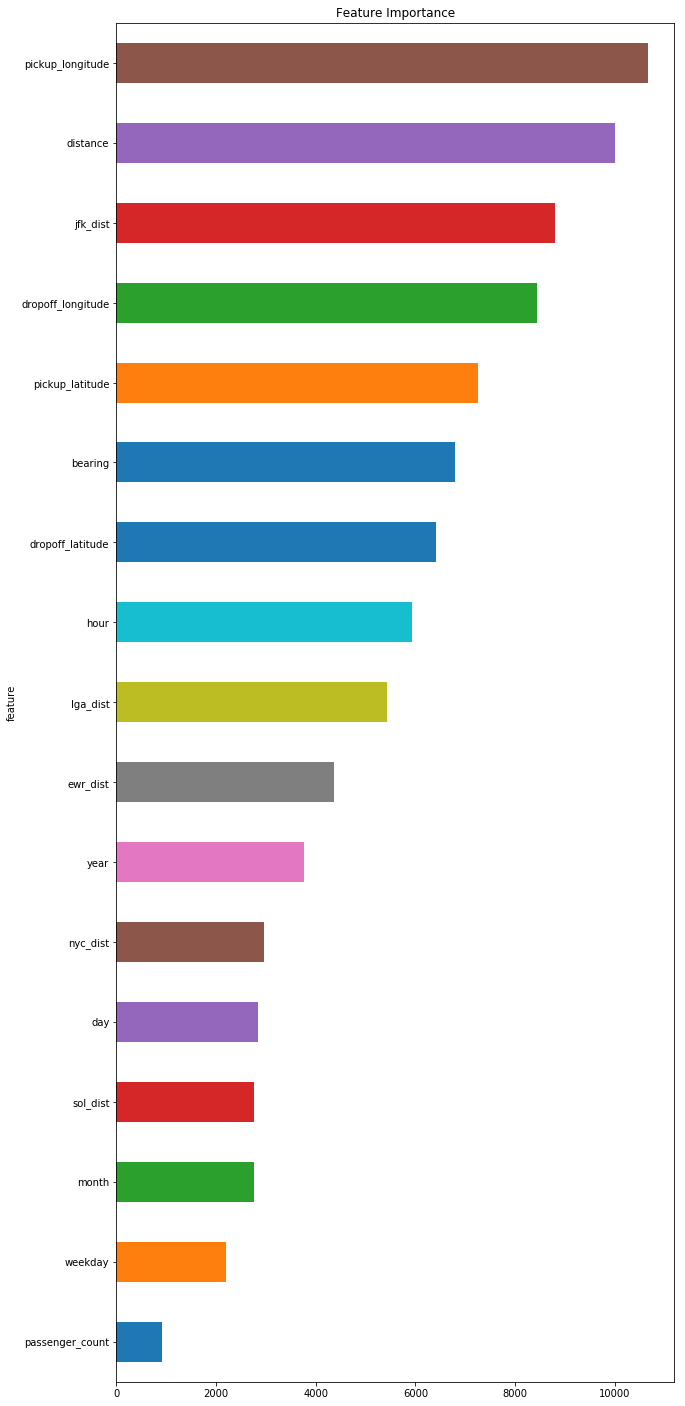

In [15]:
import operator
importance=model.get_score()
importance = sorted(importance.items(), key=operator.itemgetter(1))
df = pd.DataFrame(importance, columns=['feature', 'score'])
plt.figure()

df.plot(kind='barh', x='feature', y='score', legend=False, figsize=(10, 25))
plt.title("Feature Importance")

In [16]:
#Wczytywanie zbioru testowego
dfTest =  pd.read_csv('test.csv')
dfTest = add_datetime_info(dfTest)
dfTest = add_airport_dist(dfTest)
dfTest['distance'] = sphere_dist(dfTest['pickup_latitude'], dfTest['pickup_longitude'], 
                                   dfTest['dropoff_latitude'] , dfTest['dropoff_longitude'])
dfTest['bearing'] = sphere_dist_bear(dfTest['pickup_latitude'], dfTest['pickup_longitude'], 
                                   dfTest['dropoff_latitude'] , dfTest['dropoff_longitude'])  

test_key = dfTest['key']
x_pred = dfTest.drop(columns=['key', 'pickup_datetime'])

#Przewidywanie używając XGBoost
predykcja = model.predict(xgb.DMatrix(x_pred), ntree_limit = model.best_ntree_limit)

### Podsumowanie

In [17]:
submission = pd.DataFrame({
        "key": test_key,
        "fare_amount": predykcja.round(2)
})

submission.to_csv('podsumowaniefinal.csv',index=False)
submission.head()

,key,fare_amount
0,2015-01-27 13:08:24.0000002,10.60
1,2015-01-27 13:08:24.0000003,11.27
2,2011-10-08 11:53:44.0000002,5.14
3,2012-12-01 21:12:12.0000002,8.34
4,2012-12-01 21:12:12.0000003,15.83
